# 1. Preparing Tool Box

In [2]:
import os
for dirname, _, filenames in os.walk('\pkbhx\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

\pkbhx\data\pkbhx.csv


In [4]:
# Import necessary modules

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tpot import TPOTRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 2. Reading the Data

In [25]:
# Create a DataFrame
data = pd.read_csv('\pkbhx\data\pkbhx.csv', sep=';')

# 3. Data Cleaning and Pre-processing

In [6]:
# Is there any null values?
print(data.isnull().values.any())

False


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  993 non-null    object 
 1   pK_BHX  993 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.6+ KB


In [26]:
# There might be one or more valid SMILES that can represent one compound
# Generate Canonical SMILES
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [27]:
Canon_SMILES = canonical_smiles(data.SMILES)

# Put the smiles in the dataframe
data['SMILES'] = Canon_SMILES

In [10]:
# Analyzing the duplicates
print(f'{data.duplicated().sum()} duplicated records in {len(data)} total records.\n',
      f'Resulting in {data.duplicated().sum()/len(data)*100:.1f}% of duplicated records.')

0 duplicated records in 993 total records.
 Resulting in 0.0% of duplicated records.


In [28]:
# The RDKit package calculates the molecular descriptors like
# molecular weight, the number of valence electrons, and the maximum
# and minimum partial charge for all molecules using as input the
# SMILE representation.
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
rdkit_2d_desc = []
for k in range(len(data)):
  header = calc.GetDescriptorNames()
  d = calc.CalcDescriptors(Chem.MolFromSmiles(data.iloc[k, 0]))
  rdkit_2d_desc.append(d)

temp_df = pd.DataFrame(rdkit_2d_desc, columns=header)  

data = pd.concat([data, temp_df], axis=1)

In [29]:
# Is there any null values?
print(data.isnull().values.any())

True


In [30]:
data[data.isnull().any(axis=1)]

,SMILES,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
697,c1ccc(C[Se](Cc2ccccc2)=[O:1])cc1,3.30,11.990193,-1.770000,11.990193,0.731879,0.785197,277.225,263.113,278.020986,...,0,0,0,0,0,0,0,0,0,0
698,C[Se](C)=[O:1],3.43,9.652778,-1.291667,9.652778,1.291667,0.434580,125.029,118.981,125.958386,...,0,0,0,0,0,0,0,0,0,0
839,c1ccc(P(c2ccccc2)(c2ccccc2)=[Se:1])cc1,0.94,3.550556,-1.651435,3.550556,1.372593,0.507427,341.252,326.132,342.007658,...,0,0,0,0,0,0,0,0,0,0
847,c1ccc([As](c2ccccc2)(c2ccccc2)=[O:1])cc1,4.15,13.878819,-3.544896,13.878819,0.933356,0.675029,322.239,307.119,322.033887,...,0,0,0,0,0,0,0,0,0,0
903,C[Se:1]C,-0.01,2.187500,0.875000,2.187500,0.875000,0.403159,109.030,102.982,109.963471,...,0,0,0,0,0,0,0,0,0,0


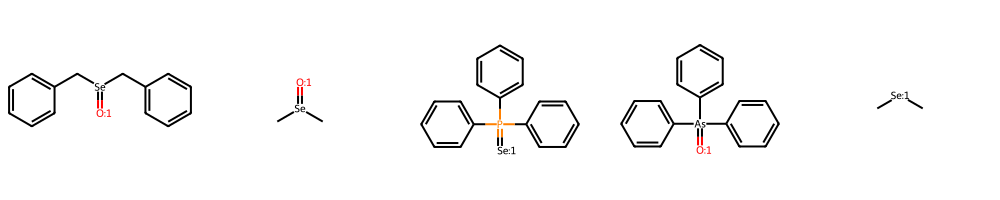

In [31]:
# Let's look at the molecules that generated descriptors with nan values
nan_df = data[data.isnull().any(axis=1)][['SMILES']]
mols = [Chem.MolFromSmiles(smi) for smi in nan_df.SMILES]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

In [32]:
# Columns with nan values
na_names = data.isnull().any()
list(na_names.where(na_names == True).dropna().index)

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

The RDKit package failed to calculate some descriptors values, so the action taken was to attribute the missing values

In [33]:
header = list(data.columns)

# Imputing missing values with mean column value using SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')
si = si.fit(data.drop(columns='SMILES'))

data_si = pd.DataFrame(si.transform(data.drop(columns='SMILES')))
data = pd.concat([data['SMILES'], data_si], axis=1)
data.columns = header

In [34]:
# Is there any null values?
print(data.isnull().values.any())

False


In [35]:
# Drop the column SMILES
data.drop(columns=['SMILES'], inplace=True)

In [36]:
data.shape

(993, 209)

In [37]:
data.head(5)

,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.90,10.605370,0.058426,10.605370,0.058426,0.523744,121.139,114.083,121.052764,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.78,5.006944,0.888889,5.006944,0.888889,0.434057,87.122,78.050,87.068414,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.67,3.263889,1.212963,3.263889,1.212963,0.473722,103.190,94.118,103.045570,36.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.10,3.185185,1.166667,3.185185,1.166667,0.457255,89.163,82.107,89.029920,30.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.56,5.098194,0.913194,5.098194,0.913194,0.423889,101.149,90.061,101.084064,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
data_y = data['pK_BHX']
data_X = data.drop(columns=['pK_BHX'])

In [39]:
data_X.shape

(993, 208)

In [40]:
# Use a variance threshold to remove any feature that has little to no variation in their values
header = list(data_X.columns)

vt = VarianceThreshold()
data_X = vt.fit_transform(data_X)

cols = vt.get_support(indices=True)

selected_features = []
for i in range(len(cols)):
    selected_features.append(header[cols[i]])

data_X = pd.DataFrame(data_X, columns=selected_features)

In [41]:
data_X.shape

(993, 186)

In [42]:
# Find and remove features with Pearson
# correlation equal to or higher than the threshold 
def correlation(dataset, threshold):
    col_corr = set()
    
    corr_matrix = dataset.corr(method="pearson") # Compute pairwise Pearson correlation coefficients
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) >= threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    
    dataset.drop(col_corr, axis=1, inplace=True)
    
    return dataset

In [43]:
# Remove feature(s) with Pearson correlation equal to or higher than 0.95 
data_X = correlation(data_X, 0.95)

In [44]:
data_X.shape

(993, 156)

In [45]:
# Split Data into Training (80%) and Test set (20%)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [46]:
def my_rmse(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

rmse_scorer = make_scorer(my_rmse, greater_is_better=False)

# 4. Setting Models

Models: 

1. Support Vector Machine (SVR)
2. K-Nearest Neighbors (NN)
3. Light Gradient Boosting (LGB)
4. Random Forest (RF)
5. Tree-based Pipeline Optimization Tool (TPOT)

In [47]:
# Prepare a DataFrame that will store the scoring metrics for each model
metrics = pd.DataFrame(index=['R**2', 'Mean Absolute Error (MAE)', 'Mean Square Error (MSE)', 'Root Mean Square Error (RMSE)'],
                       columns=['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', 'Random Forest', 'TPOT'])

In [48]:
def gridsearch_hyper(model_name, estimator, parameter_grid):
  gs = GridSearchCV(estimator, parameter_grid, cv=5, scoring=rmse_scorer)

  # Fit on Training
  gs.fit(X_train, y_train)
  
  # Predict on Test
  y_pred = gs.predict(X_test)

  # Scoring
  metrics.loc['R**2', model_name] = r2_score(y_test, y_pred)
  metrics.loc['Mean Absolute Error (MAE)', model_name] = mean_absolute_error(y_test, y_pred)
  metrics.loc['Mean Square Error (MSE)', model_name] = mean_squared_error(y_test, y_pred)
  metrics.loc['Root Mean Square Error (RMSE)', model_name] = mean_squared_error(y_test, y_pred, squared=False)

  print(f'Best parameters to {model_name}: {gs.best_params_}')

In [49]:
# Space of hyperparameters and estimators we want to search through
model_name = ['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', "Random Forest"]

parameter_grid_dr = {
    'estimator__strategy':['mean', 'median']
}

parameter_grid_svr = {
    'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree':[3, 4, 5],
    'estimator__gamma':['scale', 'auto'],
    'estimator__coef0':[0.1, 0.25, 0.5, 1.0, 3.0, 5.0],
    'estimator__C':[0.01, 0.1, 0.25, 0.5, 1.0, 3.0, 5.0]
}

parameter_grid_nn = {
    'estimator__n_neighbors':[5, 6, 8, 10],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__weights':['uniform', 'distance']
}

parameter_grid_lgb = {
    'estimator__learning_rate':[0.001, 0.01, 0.1],
    'estimator__max_depth':[4, 6, 8, 10],
    'estimator__tree_learner':['serial', 'feature', 'data', 'voting']
}

parameter_grid_rf = {
    'estimator__n_estimators':[10, 25, 50, 100],
    'estimator__criterion':['squared_error', 'absolute_error'],
    'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__max_features':['auto', 'sqrt', 'log2']
}

Base Model: Dummy Model

In [50]:
model_dr = DummyRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_dr)])
gs_dr = gridsearch_hyper('Dummy Regressor', pipe, parameter_grid_dr)

Best parameters to Dummy Regressor: {'estimator__strategy': 'mean'}


1st Model: Support Vector Machine (SVR)

In [60]:
model_svr = SVR()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_svr)])
gs_svr = gridsearch_hyper('Support Vector Machine', pipe, parameter_grid_svr)

2nd Model: K-Nearest Neighbors (NN)

In [52]:
model_nn = KNeighborsRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_nn)])
gs_nn = gridsearch_hyper('Nearest Neighbors', pipe, parameter_grid_nn)

Best parameters to Nearest Neighbors: {'estimator__algorithm': 'ball_tree', 'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}


3rd Model: Light Gradient Boosting (LGB)

In [54]:
model_lgb = lgb.LGBMRegressor(random_state=0, verbosity=-1)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_lgb)])
gs_lgb = gridsearch_hyper('Light Gradient Boosting', pipe, parameter_grid_lgb)

Best parameters to Light Gradient Boosting: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__tree_learner': 'serial'}


4th Model: Random Forest (RF)

In [56]:
model_rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_rf)])
gs_rf = gridsearch_hyper('Random Forest', pipe, parameter_grid_rf)

Best parameters to Random Forest: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 10, 'estimator__max_features': 'auto', 'estimator__n_estimators': 100}


5th Model: Tree-based Pipeline Optimization Tool (TPOT)

In [ ]:
tpot_regressor = TPOTRegressor(generations=5, population_size=1000, scoring=rmse_scorer, n_jobs=-1, verbosity=2, random_state=0)
tpot_regressor.fit(X_train.values, y_train)
tpot_regressor.export('/pkbhx/data/tpot_exported_pipeline_g5_p1000.py')

Optimization Progress:   0%|          | 0/6000 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.41972182641258354

Generation 2 - Current best internal CV score: -0.4177929782545048


In [638]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.4195830491185232
exported_pipeline = make_pipeline(
    StandardScaler(),
    SelectFwe(score_func=f_regression, alpha=0.015),
    XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=1.0, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(X_train, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfwe',
                 SelectFwe(alpha=0.015,
                           score_func=<function f_regression at 0x0000026DC5FFA040>)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...one, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=10, max_leaves=0, min_child_weight=7,
                         

In [636]:
y_hat = pd.DataFrame(exported_pipeline.predict(X_test))
metrics.loc['R**2', 'TPOT'] = r2_score(y_test, y_hat)
metrics.loc['Mean Absolute Error (MAE)', 'TPOT'] = mean_absolute_error(y_test, y_hat)
metrics.loc['Mean Square Error (MSE)', 'TPOT'] = mean_squared_error(y_test, y_hat)
metrics.loc['Root Mean Square Error (RMSE)', 'TPOT'] = mean_squared_error(y_test, y_hat, squared=False)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
metrics

,Dummy Regressor,Support Vector Machine,Nearest Neighbors,Light Gradient Boosting,Random Forest,TPOT
R**2,-0.005299,NaN,0.722685,0.772499,0.770272,NaN
Mean Absolute Error (MAE),0.732584,NaN,0.324339,0.276302,0.283361,NaN
Mean Square Error (MSE),0.850519,NaN,0.234618,0.192474,0.194358,NaN
Root Mean Square Error (RMSE),0.922236,NaN,0.484374,0.438719,0.440861,NaN


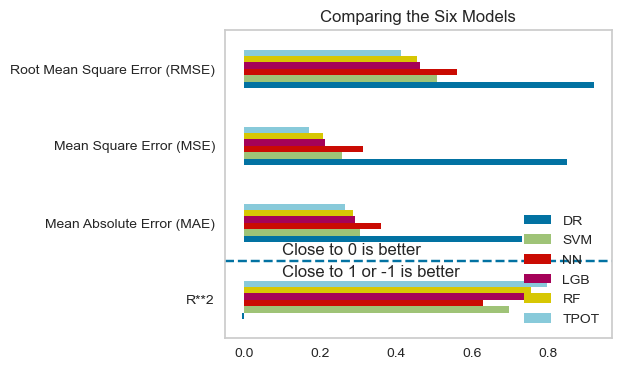

In [376]:
fig, ax = plt.subplots(figsize=(5, 4))
metrics.plot(kind='barh', ax=ax)
ax.grid()
ax.set_title('Comparing the Six Models')
plt.legend(['DR', 'SVM', 'NN', 'LGB', 'RF', 'TPOT'], loc=4, shadow=True)
plt.annotate('Close to 0 is better', xy=(0.1, 0.58))
plt.annotate('Close to 1 or -1 is better', xy=(0.1, 0.3))
plt.axhline(y=0.5, linestyle='--')
plt.show()

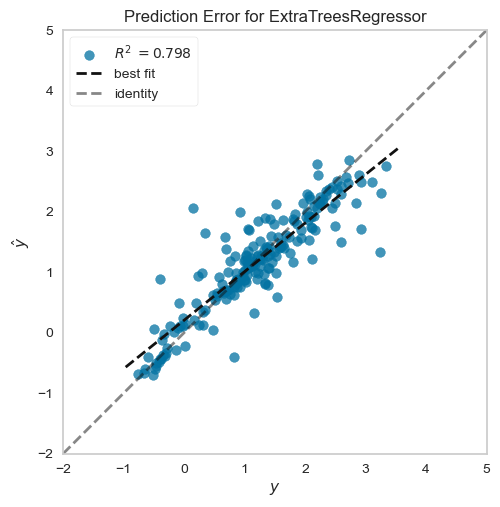

<AxesSubplot:title={'center':'Prediction Error for ExtraTreesRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [377]:
# Instantiate the linear model and visualizer
pred_visualizer = PredictionError(exported_pipeline)

pred_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
pred_visualizer.ax.set_xlim(left=-2, right=5)
pred_visualizer.ax.set_ylim(bottom=-2, top=5)
pred_visualizer.ax.grid(False)
pred_visualizer.show()                 # Finalize and render the figure

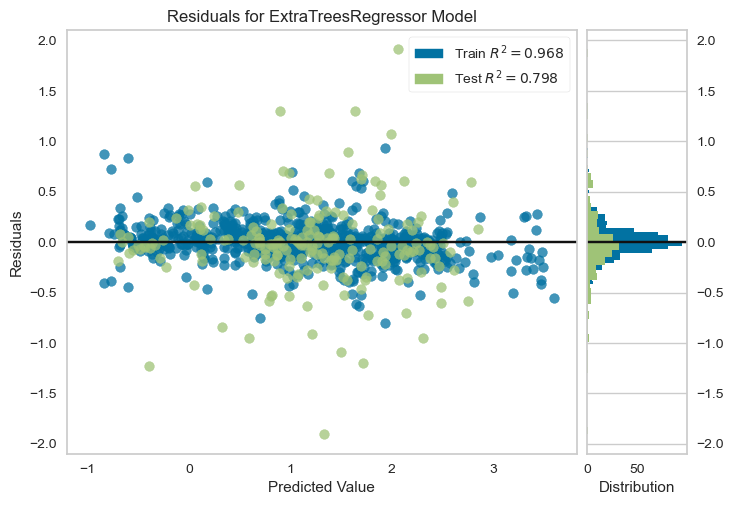

<AxesSubplot:title={'center':'Residuals for ExtraTreesRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [274]:
res_visualizer = ResidualsPlot(exported_pipeline)

res_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
res_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
res_visualizer.ax.grid(False)
res_visualizer.show()  

In [380]:
y_hat.columns = ['pkbhx']

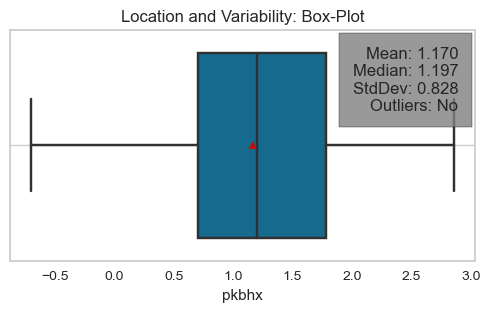

In [381]:
fig, ax = plt.subplots(figsize=(6, 3))

# Boxplot
sns.boxplot(data=y_hat_, x=y_hat['pkbhx'], ax=ax, showmeans=True)
ax.set_title('Location and Variability: Box-Plot')

# Check outliers
q1 =y_hat['pkbhx'].quantile(0.25)
q3 = y_hat['pkbhx'].quantile(0.75)
iqr = q3 - q1

# calculate the outlier cutoff
lower, upper = q1-(1.5*iqr), q3+(1.5*iqr)

outliers = (y_hat['pkbhx'][(y_hat['pkbhx'] < lower) | (y_hat['pkbhx'] > upper)])

if outliers.empty:
    has_outliers = 'No'
else:
    has_outliers = 'Yes'

# Presenting the stats
ax.annotate(text=f'Mean: {y_hat["pkbhx"].mean():.3f}\n'
                    f'Median: {y_hat["pkbhx"].median():.3f}\n'
                    f'StdDev: {y_hat["pkbhx"].std():.3f}\n'
                    f'Outliers: {has_outliers}',
                    xy=(1,1), xytext=(-12,-12), xycoords='axes fraction',
                    textcoords='offset points', ha='right', va='top',
                    bbox=dict(facecolor='grey', alpha=0.8, pad=10))
ax.grid()
plt.show()